In [2]:
from mcap_processing import open_files_in_folder, merge_dictionaries, convert_dict_to_pandas_df, get_start_end_times, get_all_msgs_from_mcap, get_important_data_for_times
from functools import reduce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### data loading
these function evals load the mcap data on your local machine for processing with the below blocks

In [8]:
mcap_readers, files = open_files_in_folder("./mcaps/raw")

msgs_total = {}
for reader in mcap_readers:
    msgs_total = merge_dictionaries(msgs_total, get_all_msgs_from_mcap(reader))
df = convert_dict_to_pandas_df(msgs_total)
important_times = get_start_end_times(df, "mcu_status_data", "ecu_state", "5")
cut_df = get_important_data_for_times(df, important_times)

/home/ben/hytech/mcap_analysis/./mcaps/raw/07_28_2023_16_04_22_test.mcap


/home/ben/hytech/mcap_analysis/mcap_processing.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  msgs[topic_attr_name] = msgs['proto_msg'].apply(lambda x: getattr(x, topic_attr_name))


### plotting helper functions
TODO maybe move into local python lib?

In [43]:
def time_plot_msg_member(df, topic, pb_msg_member):
    msgs = df[df['topic'] == topic]
    msgs[pb_msg_member] = msgs['proto_msg'].apply(lambda x: getattr(x, pb_msg_member))
    msgs.plot(x='log_time', y=pb_msg_member)
    plt.show()

def time_plot_multi_msg_members(df, topic, pb_msg_members_list):
    msgs = df[df['topic'] == topic]
    plt.figure(figsize=(16, 8), dpi=150) 
    for pb_msg_member in pb_msg_members_list:
        msgs[pb_msg_member] = msgs['proto_msg'].apply(lambda x: getattr(x, pb_msg_member))
    msgs.plot(x='log_time', y=pb_msg_members_list)
    plt.show()

def multi_topic_time_plot_multi_msg_members(df, topic_msg_member_list_dict):
    member_list = []
    msgs_to_plot = {}
    df_list = []
    for key, value in topic_msg_member_list_dict.items():
        member_list.extend(value[0])
        
        msgs = df[df['topic'] == key]
        for pb_msg_member in value[0]:
            
            msgs[pb_msg_member] = msgs['proto_msg'].apply(lambda x: getattr(x, pb_msg_member))
            normalize = value[1]
            if(normalize):
                msgs[pb_msg_member] = msgs[pb_msg_member] / msgs[pb_msg_member].abs().max()
        df_list.append(msgs)
    
    
    total_col_list = member_list + ['log_time']
    merged_df = df_list[0]
    for i in range(len(df_list) - 1 ):
        i=i+1
        print(merged_df.columns)
        merged_df = pd.merge_asof(merged_df, df_list[i], on='log_time', tolerance=pd.Timedelta('100ms'))
        merged_df = merged_df[merged_df.columns.intersection(total_col_list)]
    # print(merged_df)
    merged_df.plot(x='log_time', y=member_list, figsize=(32,16))
    # plt.figure(figsize=(32, 16), dpi=150)
    plt.show()

### pandas dataframe processors
- `get_time_range_df` returns a dataframe containing only messages between the start and end epoch times (can be easily gotten from foxglove)

In [10]:
def get_time_range_df(df, start_time_epoch_sec, end_time_epoch_sec):
    return df[(((((df['log_time']- pd.Timestamp("1970-01-01")) // pd.Timedelta("1ns")) / 1e9) >= start_time_epoch_sec) & ((((df['log_time']- pd.Timestamp("1970-01-01")) // pd.Timedelta("1ns")) / 1e9) <= end_time_epoch_sec))]


Index(['topic', 'schema', 'channel', 'message', 'proto_msg', 'log_time',
       'potentiometer_fl', 'potentiometer_fr'],
      dtype='object')
Index(['log_time', 'potentiometer_fl', 'potentiometer_fr', 'potentiometer_rl',
       'potentiometer_rr'],
      dtype='object')
Index(['log_time', 'potentiometer_fl', 'potentiometer_fr', 'potentiometer_rl',
       'potentiometer_rr', 'brake_percent_float'],
      dtype='object')


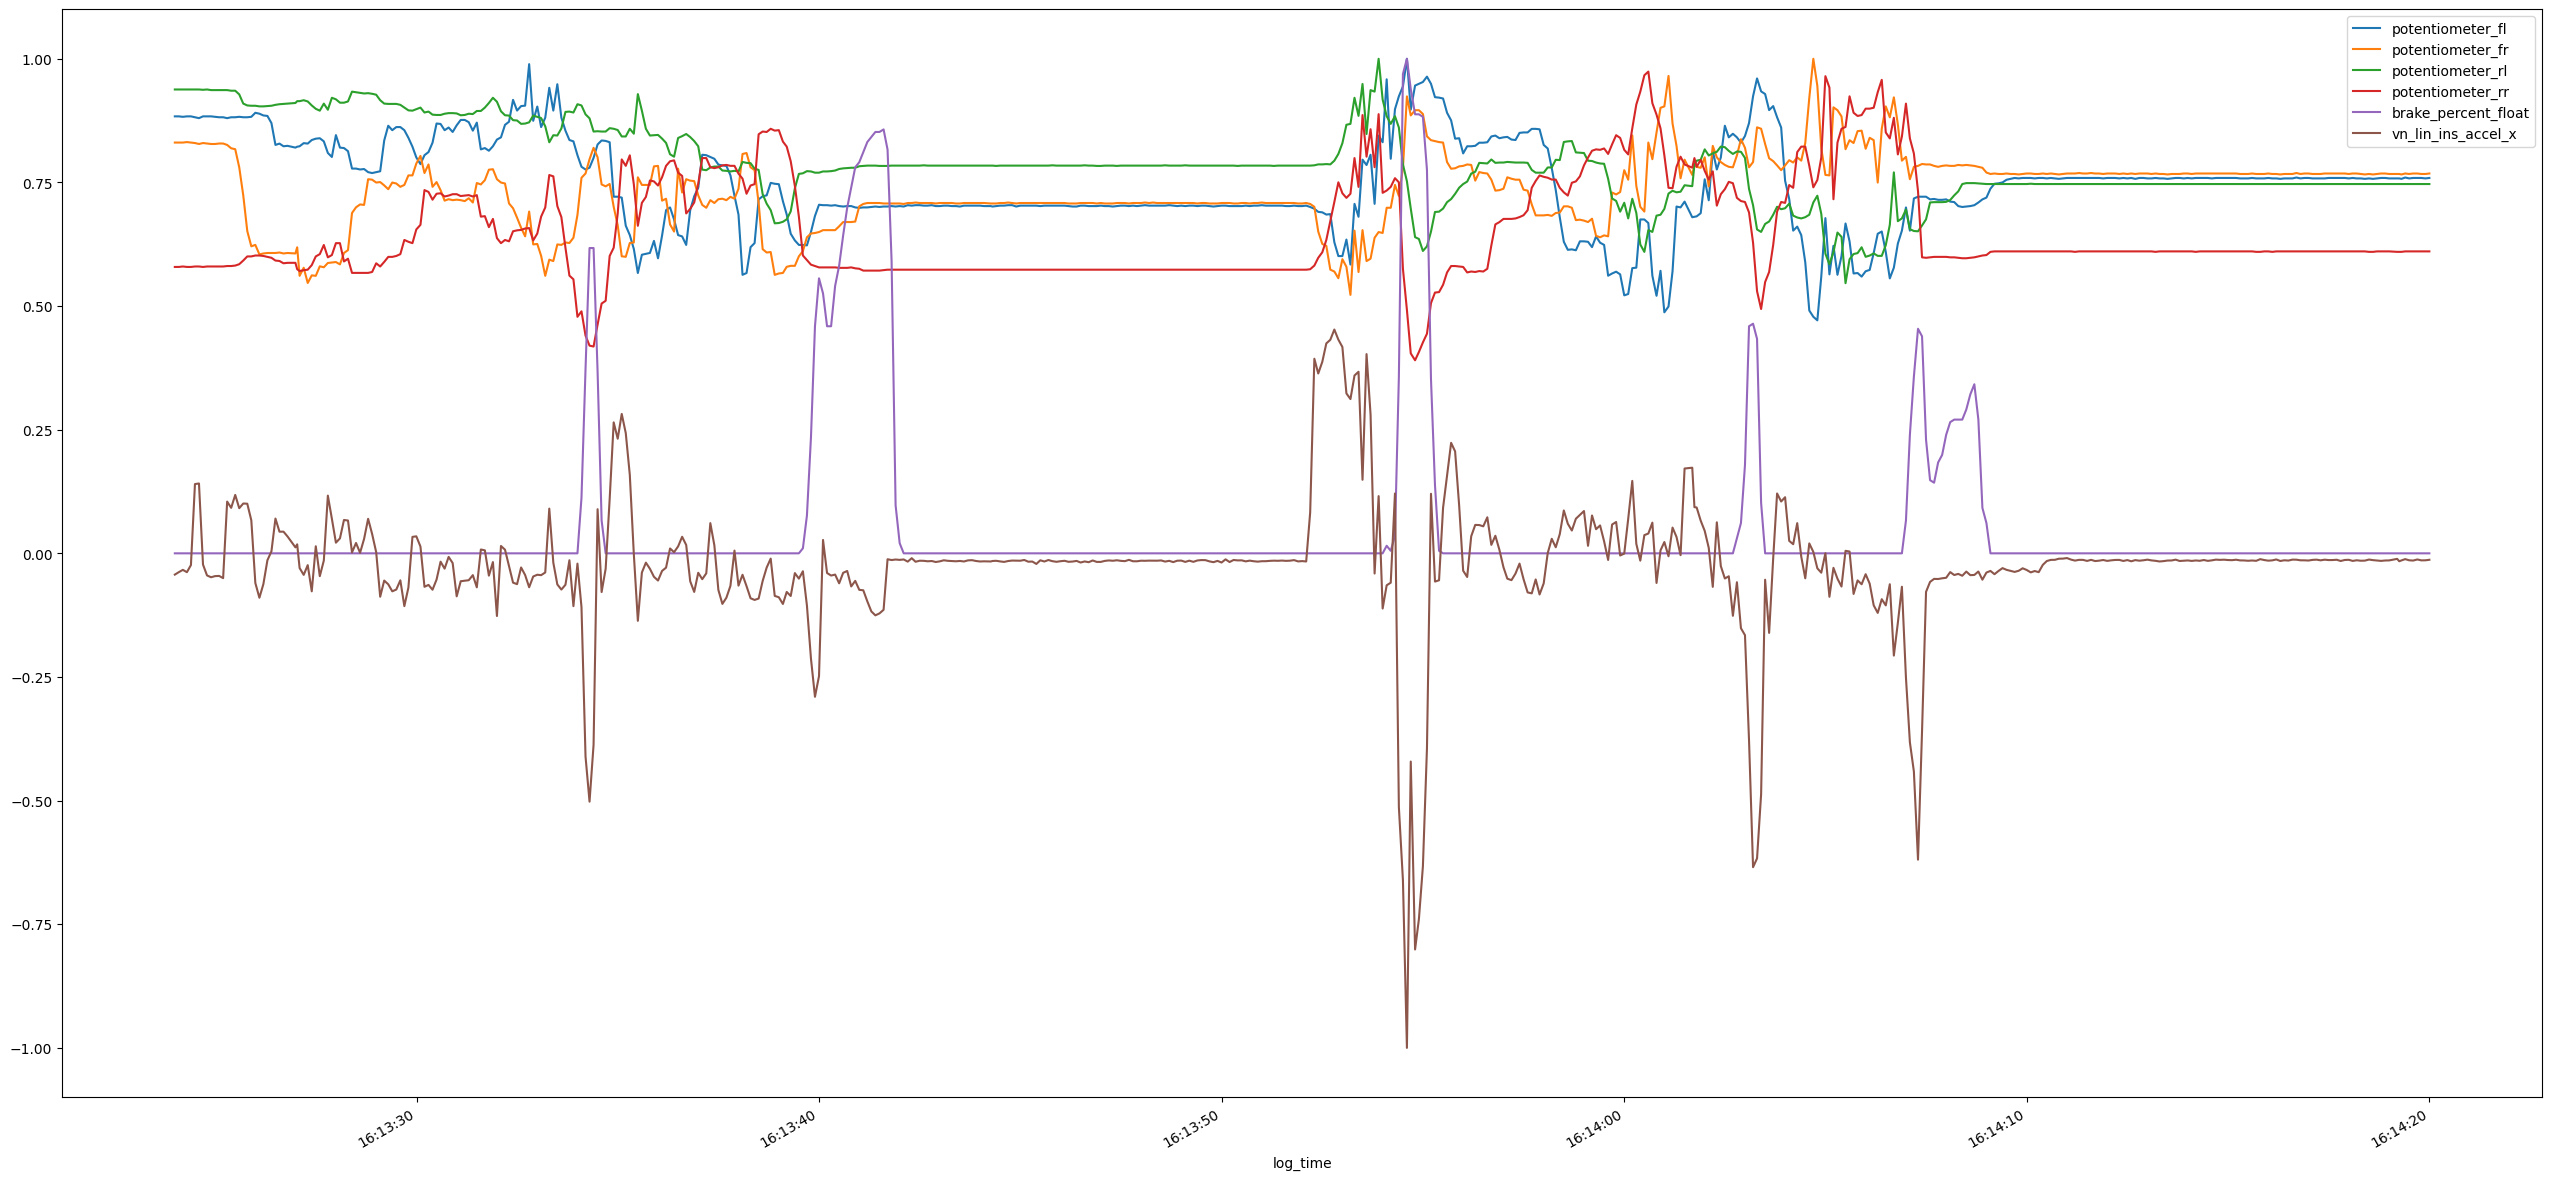

In [44]:
pd.options.mode.copy_on_write = True
def analyze_sus_pots(msgs_df):
    
    # time_plot_msg_member(msgs_df, 'mcu_suspension_data', 'potentiometer_fr')
    # time_plot_multi_msg_members(msgs_df, 'mcu_suspension_data', ['potentiometer_fl', 'potentiometer_fr'])
    msgs_dict = {
        "mcu_suspension_data": [['potentiometer_fl', 'potentiometer_fr'], True],
        "sab_suspension_data": [['potentiometer_rl', 'potentiometer_rr'], True],
        "mcu_pedal_readings_data": [['brake_percent_float'], True],
        "vn_linear_accel_data": [['vn_lin_ins_accel_x'], True]
    }
    multi_topic_time_plot_multi_msg_members(msgs_df, msgs_dict)

pd.set_option('float_format', '{:f}'.format)
# print( (((cut_df['log_time']- pd.Timestamp("1970-01-01")) // pd.Timedelta("1ns")) / 1e9))
cut_df = get_time_range_df(cut_df, 1690560803.912279230,1690560860.036473048)
analyze_sus_pots(cut_df)
